In [1]:
import sys
from my_weapon import *
from tqdm import tqdm_notebook as tqdm
from fake_identify import Are_you_IRA
import matplotlib
from collections import Counter
# matplotlib.rcParams["font.size"] = 14
# sns.set_style("darkgrid")

ira_c = sns.color_palette("coolwarm", 8)[7]
all_c = sns.color_palette("coolwarm", 8)[0]
sns.set(style="darkgrid", font_scale=1.2)
Putin = Are_you_IRA()

In [22]:
from infomap import Infomap

def findCommunities(G, mt=1):
    """
    Partition network with the Infomap algorithm.
    Annotates nodes with 'community' id and return number of communities found.
    """
    infomapWrapper = Infomap(f"--two-level --silent --markov-time {mt} -N 10")

#     print("Building Infomap network from a NetworkX graph...")
    
    for e in G.edges(data=True):
        e = (G.node[e[0]]["id"], G.node[e[1]]["id"])
#         e = (G.node[e[0]]["id"], G.node[e[1]]["id"])
        # print(e)
        infomapWrapper.addLink(*e)

#     print("Find communities with Infomap...")
    infomapWrapper.run();

#     print("Found %d modules with codelength: %f" % (infomapWrapper.numTopModules(), infomapWrapper.codelength()))
    
    communities = {}
#     for node in infomapWrapper.iterTree():
#         print("{} {}".format(node.path(), node.physicalId))

    ix_to_name = {G.node[name]["id"]: name for name in G.nodes()}
    # print(ix_to_name)

    for node in infomapWrapper.iterTree():
        if node.isLeaf():
            # f.write("{}\t{}\t{}\n".format(ix_to_name[node.physicalId], node.physicalId, node.moduleIndex()))
            communities[ix_to_name[node.physicalId]] = node.moduleIndex()
    
    nx.set_node_attributes(G, name='community_Infomap', values=communities)

    return G, communities, infomapWrapper.numTopModules(), infomapWrapper.codelength()

In [336]:
G = nx.read_gpickle("disk/ira-ret.gp")
# G

In [337]:
G.number_of_nodes(), G.number_of_edges()

(154366, 360265)

In [338]:
G = G.subgraph(max(nx.weakly_connected_components(G), key=len))

In [339]:
putin = Are_you_IRA()

for i, n in enumerate(G.nodes()):
    if putin.fuck(n):
        G.node[n]["IRA"] = 1
    else:
        G.node[n]["IRA"] = 0

In [340]:
G = G.to_undirected()

In [341]:
# cnt = 0

# for matlab
with open("data/ira-ret.net", "w") as f:
    f.write(f"*Vertices {G.number_of_nodes()}\n")
    for i, n in enumerate(G.nodes()):
        G.node[n]["id"] = i + 1
        f.write(f'{i+1} "{i+1}"\n')
    f.write("*Edges\n")
    
    for e in G.edges(data=True):
#         print(e)
        n1, n2 = e[0], e[1]
        f.write(f"{G.node[n1]['id']} {G.node[n2]['id']} 1\n")
    #     print(G.node[n])
                
G.number_of_nodes(), G.number_of_edges()

(154257, 359244)

In [274]:
G, comm, num, cl = findCommunities(G, mt=5)

from collections import Counter
cnt = Counter()
for k, v in comm.items():
    cnt[v] += 1
print(cnt.most_common(10))

json.dump(comm, open("data/ira-ret-community.json", "w"), indent=2)

# ira_rst["mentioning"] = get_G_char_IRA("disk/ira-men.gp")
# ira_rst["replying"] = get_G_char_IRA("disk/ira-rep.gp")
# ira_rst["quoting"] = get_G_char_IRA("disk/ira-quo.gp")

[(0, 120724), (2, 22731), (1, 7947), (6, 552), (22, 262), (20, 209), (7, 179), (4, 142), (13, 127), (129, 118)]


In [10]:
from collections import Counter
rst = []

for i in tqdm(np.arange(1, 11, 1)):
#     print(f"\n***** --markov-time ={i} *****")
    G, comm, n_mod, codelength = findCommunities(G, mt=i)
    cnt = Counter()
    for k, v in comm.items():
        cnt[v] += 1
    print("Size of top 10 communities:", [s for n, s in cnt.most_common(10)])
    rst.append([i, n_mod, codelength, cnt.most_common(10)])

Size of top 10 communities: [34097, 15849, 15446, 7733, 6776, 5321, 5286, 4753, 4659, 4393]
Size of top 10 communities: [133167, 7784, 6613, 1473, 1125, 823, 479, 358, 242, 173]
Size of top 10 communities: [143984, 6641, 1133, 484, 281, 169, 137, 136, 118, 117]
Size of top 10 communities: [144179, 7791, 617, 370, 169, 154, 138, 118, 101, 85]
Size of top 10 communities: [145117, 7823, 169, 169, 167, 159, 118, 117, 85, 83]
Size of top 10 communities: [153562, 169, 118, 85, 81, 42, 41, 37, 26, 21]
Size of top 10 communities: [153664, 254, 118, 42, 41, 37, 26, 20, 18, 10]
Size of top 10 communities: [153637, 169, 118, 85, 75, 42, 41, 37, 20, 12]
Size of top 10 communities: [153687, 256, 118, 73, 38, 37, 20, 12, 9, 7]
Size of top 10 communities: [153795, 258, 118, 38, 20, 12, 9, 7]


In [290]:
X = [r[0] for r in rst]
sns.set(style="white", font_scale=1.4)

Text(0, 0.5, 'Number of modules')

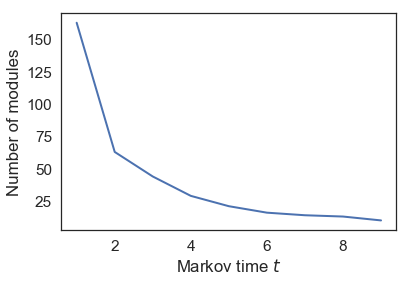

In [291]:
y = [r[1] for r in rst]
# print(y)
plt.plot(X, y, lw=2)
plt.xlabel("Markov time $t$")
plt.ylabel("Number of modules")
# plt.xscale("log")

Text(0, 0.5, 'Code length (bits)')

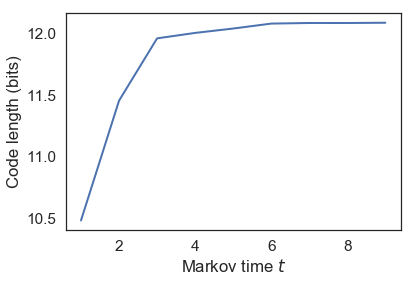

In [292]:
y = [r[2] for r in rst]
# print(y)
plt.plot(X, y, lw=2)
plt.xlabel("Markov time $t$")
plt.ylabel("Code length (bits)")
# plt.xscale("log")

Text(0, 0.5, 'Size of the largest module')

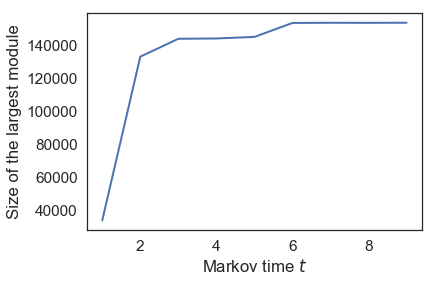

In [293]:
y = [r[3][0][1] for r in rst]
# print(y)
plt.plot(X, y, lw=2)
plt.xlabel("Markov time $t$")
plt.ylabel("Size of the largest module")
# plt.xscale("log")

In [294]:
import community

G = nx.Graph(G)
partition = community.best_partition(G)
# partition = community.best_partition(G, resolution=5)

In [295]:
cnt = Counter()
for n, c in partition.items():
    cnt[c] += 1 

In [296]:
cnt.most_common()

[(1, 49455),
 (5, 18030),
 (0, 16434),
 (9, 15082),
 (3, 13973),
 (7, 12572),
 (6, 8441),
 (4, 7774),
 (8, 7741),
 (2, 2718),
 (10, 1118),
 (13, 358),
 (14, 297),
 (17, 118),
 (15, 76),
 (11, 26),
 (16, 20),
 (18, 12),
 (12, 6),
 (19, 6)]

In [96]:
comm_nodes = {}

for n in G.nodes(data=True):
    c =  n[1]["community_Infomap"]
    if c not in comm_nodes:
        comm_nodes[c] = 0
    if n[1]["IRA"] == 1:
        comm_nodes[c] += 1

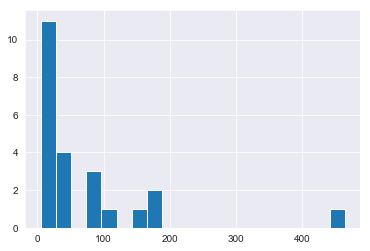

In [97]:
# 社团大小

d = pd.Series([v for v in cnt.values() if v < 1000])
# x, cdf, pdf = get_cdf_pdf(d, mini=1)
# plt.plot(x, pdf)
# plt.xscale("log")
d.hist(bins=20)

In [67]:
# for gephi

plot_these_nodes = []
keep_iras = []


for n in G.node(data=True):
#     if n[1]["community_Infomap"] in [0, 3, 23, 8, 6]:
#     if n[1]["community_Infomap"] in [0, 9, 2, 3, 4]:
    if n[1]["community_Infomap"] in [0, 1, 2]:
        if n[1]["IRA"] == 1:
            keep_iras.append(n[0])
        else:
            plot_these_nodes.append(n[0])
            
len(plot_these_nodes), len(keep_iras)

(151270, 287)

In [190]:
# random sampling for show
import random

plot_these_nodes = random.sample(plot_these_nodes, int(len(plot_these_nodes) * 0.1))
plot_these_nodes.extend(keep_iras)
G = G.subgraph(plot_these_nodes)
G = G.subgraph(max(nx.connected_components(G), key=len))

In [169]:
G = nx.Graph(G)

In [170]:
nx.write_gexf(G, "data/IRA-20190506.gexf")

### IRA关注于哪些社团？

In [ ]:
from collections import Counter

cnt = Counter()
for k, v in comm.items():
    if putin.fuck(k):
        cnt[v] += 1
    
cnt.most_common(100)

In [75]:
cnt = Counter()
for k, v in comm.items():
    cnt[v] += 1
    
print(cnt.most_common(50))
    
cnt[3], cnt[23], cnt[81], cnt[95], cnt[0]

[(0, 100991), (3, 7691), (23, 6912), (8, 6553), (6, 5060), (2, 3399), (11, 2288), (19, 1934), (1, 1743), (26, 1256), (9, 1129), (60, 1068), (14, 1051), (29, 1034), (27, 925), (4, 837), (39, 831), (28, 761), (62, 673), (25, 628), (21, 557), (61, 530), (45, 486), (52, 479), (43, 364), (81, 285), (5, 270), (65, 249), (7, 231), (56, 225), (55, 222), (40, 220), (57, 208), (64, 175), (69, 169), (44, 144), (42, 137), (24, 134), (35, 134), (50, 122), (16, 120), (95, 118), (17, 117), (22, 116), (87, 88), (10, 85), (34, 76), (31, 73), (15, 71), (12, 68)]


(7691, 6912, 285, 118, 100991)

[(3, 79),
 (23, 64),
 (81, 43),
 (95, 28),
 (0, 18),
 (5, 18),
 (67, 17),
 (105, 8),
 (25, 7),
 (11, 6)]
 
 专注3，23，84，0 三个社团，看看他们是否有不同的受众？
 
 (7691, 6910, 281, 118)

In [76]:
for n in G.nodes():
    print(n, G.node[n])
    break

4437444442 {'id': 0, 'community_Infomap': 0}


## 5. 构建交互网络!!

包括四种行为


In [455]:
G = nx.DiGraph()
G.add_edge(1, 2)
G.add_edge(2, 1)
G.number_of_nodes(), G.number_of_edges()

(2, 2)

In [456]:
n1 = nx.read_gpickle("disk/ira-ret.gp")
n2 = nx.read_gpickle("disk/ira-men.gp")
n3 = nx.read_gpickle("disk/ira-rep.gp")
n4 = nx.read_gpickle("disk/ira-quo.gp")

In [457]:
_n2 = n2.reverse()

In [459]:
G = nx.DiGraph()

G.add_edges_from(n1.edges)
# G.add_edges_from(n2.edges)
G.add_edges_from(_n2.edges)
G.add_edges_from(n3.edges)
G.add_edges_from(n4.edges)

# G = G.to_undirected()
print(G.number_of_nodes(), G.number_of_edges())
# G = G.subgraph(max(nx.weakly_connected_components(G), key=len))

G.remove_edges_from(G.selfloop_edges())
print(G.number_of_nodes(), G.number_of_edges())

179783 432532
179783 432429


In [460]:
putin = Are_you_IRA()

with open("disk/have_touched_IRA.txt", "w") as f:
    for node in G.nodes():
        if not Putin.fuck(node):
            f.write(node + "\n")
            
with open("data/first_layer_touch_IRA.txt", "w") as f:
    for i, n in enumerate(G.nodes()):
        if putin.fuck(n):
            G.node[n]["IRA"] = 1
        else:
            f.write(n + "\n")
            G.node[n]["IRA"] = 0

nx.write_gpickle(G, "data/ira-interaction.gp")

In [89]:
def save_for_matlab(G, out_name):
    print("change into undir and get the connected component")
    _G = G.to_undirected()
    _G = max(nx.connected_component_subgraphs(_G), key=len)
    print(_G.number_of_nodes(), _G.number_of_edges())

    with open(out_name, "w") as f:
        f.write(f"*Vertices {_G.number_of_nodes()}\n")
        for i, n in enumerate(_G.nodes()):
            _G.node[n]["id"] = i + 1
            f.write(f'{i} "{i}"\n')

        f.write("*Edges\n")
        for e in _G.edges(data=True):
    #         print(e)
            n1, n2 = e[0], e[1]
    #         f.write(f"{G.node[n1]['id']},{G.node[n2]['id']}\n")
            f.write(f"{_G.node[n1]['id']} {_G.node[n2]['id']} 1\n")
        #     print(G.node[n])
    return _G

In [93]:
G = nx.read_gpickle("data/ira-interaction.gp")

In [94]:
# for matlab

G = save_for_matlab(G, "data/ira-int-1-undir.net")
G.number_of_nodes(), G.number_of_edges()

change into undir and get the connected component
179682 430524


(179682, 430524)

## 6. 社团发现（Matlab结果分析）

In [68]:
d_vi = np.loadtxt("disk/comm-rst-1.txt")
# d_vi = np.loadtxt("disk/comm-rst-interaction.txt")

In [69]:
d_vi.shape

(179686, 100)

In [70]:
time = d_vi[0]
S = d_vi[1]
N = d_vi[2]
VI = d_vi[3]

In [74]:
for i in range(d_vi.shape[1]):
    if N[i] <= 4:
        print(f"{i}\t{time[i]:.3f}\t{N[i]}\t{VI[i]}")

73	8.902	4.0	0.00097447895
74	9.770	4.0	0.0012754848
75	10.723	3.0	0.00096558407
76	11.768	3.0	0.001757754
77	12.915	4.0	0.0025324445
78	14.175	4.0	0.016618804
79	15.557	2.0	0.0013853461
80	17.074	4.0	0.00034008989
81	18.738	3.0	0.00012463189
82	20.565	3.0	0.00016465962
83	22.570	2.0	5.5426998e-05
84	24.771	1.0	0.0
85	27.186	1.0	0.0
86	29.836	1.0	0.0
87	32.745	1.0	0.0
88	35.938	1.0	0.0
89	39.442	1.0	0.0
90	43.288	1.0	0.0
91	47.508	1.0	0.0
92	52.140	1.0	0.0
93	57.224	1.0	0.0
94	62.803	1.0	0.0
95	68.926	1.0	0.0
96	75.646	1.0	0.0
97	83.022	1.0	0.0
98	91.116	1.0	0.0
99	100.000	1.0	0.0


Text(0.5, 0, 'Markov time')

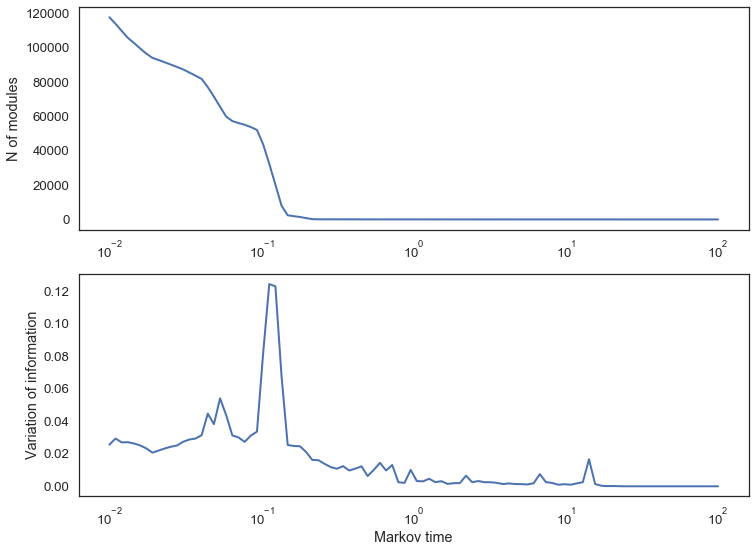

In [75]:
plt.figure(figsize=(12, 9))
# plt.subplot(3, 1, 1)
# plt.plot(time, S)
# plt.ylabel("Stability")
# plt.xscale("log")

plt.subplot(2, 1, 1)
plt.plot(time, N, lw=2)
plt.ylabel("N of modules")
plt.xscale("log")

plt.subplot(2, 1, 2)
plt.plot(time, VI, lw=2)
plt.ylabel("Variation of information")
plt.xscale("log")
plt.xlabel("Markov time")

In [76]:
# for i in range(len(time)):
#     print(i, time[i], VI[i])

time = d_vi[0, 35:90]
S = d_vi[1, 35:90]
N = d_vi[2, 35:90]
VI = d_vi[3, 35:90]

Text(0.5, 0, 'Markov time')

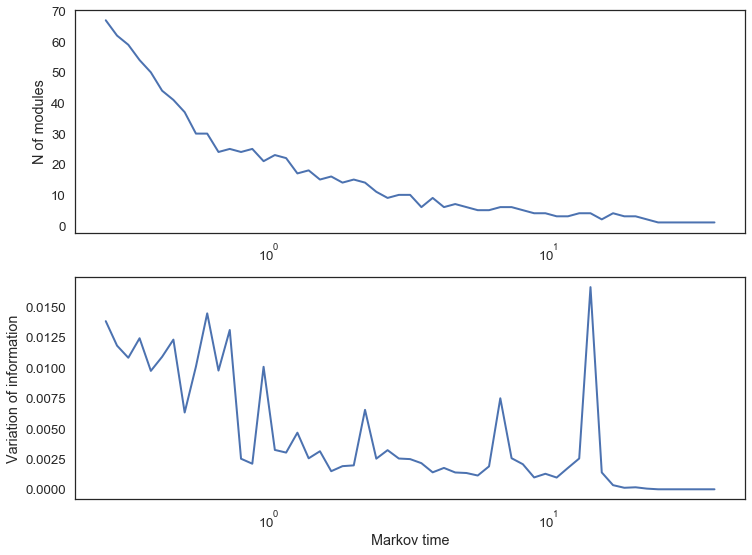

In [77]:
plt.figure(figsize=(12, 9))
# plt.subplot(3, 1, 1)
# plt.plot(time, S)
# plt.ylabel("Stability")
# plt.xscale("log")

plt.subplot(2, 1, 1)
plt.plot(time, N, lw=2)
plt.ylabel("N of modules")
plt.xscale("log")

plt.subplot(2, 1, 2)
plt.plot(time, VI, lw=2)
plt.ylabel("Variation of information")
plt.xscale("log")
plt.xlabel("Markov time")

In [81]:
rst = d_vi[4:, 73]
# rst = d_vi[4:, 48]

new_d = {}
for i, c in enumerate(rst):
    new_d[i+1] = int(c)

In [95]:
# 赋予所属社团

new_dd = {}
for n in G.node():
    G.node[n]["mod"] = new_d[G.node[n]["id"]]
    new_dd[n] = new_d[G.node[n]["id"]]
    
json.dump(new_dd, open("data/louvain_rst_4.json", "w"), indent=2)

In [376]:
comm_nodes = Counter()

for n in G.nodes(data=True):
    c =  n[1]["mod"]
    if n[1]["IRA"] == 1:
        comm_nodes[c] += 1
        
comm_nodes.most_common()

[(1, 233), (0, 134), (3, 95), (2, 35)]

In [377]:
comm_nodes = Counter()

for n in G.nodes(data=True):
    c =  n[1]["mod"]
    comm_nodes[c] += 1
        
comm_nodes.most_common()

[(0, 137953), (1, 31940), (3, 9624), (2, 165)]

In [378]:
# for gephi

plot_these_nodes = []
keep_iras = []


for n in G.node(data=True):
#     if n[1]["mod"] in [7, 1, 11, 3, 2, 8, 6]:
#     if n[1]["mod"] in [1, 8, 14, 4, 0, 11, 3, 13, 7, 2]:
    if n[1]["mod"] in [0, 1, 3]:
        if n[1]["IRA"] == 1:
            keep_iras.append(n[0])
        else:
            plot_these_nodes.append(n[0])
            
len(plot_these_nodes), len(keep_iras)

(179055, 462)

In [379]:
# random sampling for show
import random

plot_these_nodes = random.sample(plot_these_nodes, int(len(plot_these_nodes) * 0.1))
plot_these_nodes.extend(keep_iras)
G = G.subgraph(plot_these_nodes)
G = G.subgraph(max(nx.connected_components(G), key=len))

In [380]:
G = nx.Graph(G)

In [381]:
nx.write_gexf(G, "data/IRA-1-20190701.gexf")

## The 2nd layer of interaction network

1. 取出每个社团传递的消息（两个节点都需要在某社团中）
2. 定义每个社团的话题和#hashtags
3. 找到更多传播的相关信息（相关话题和hashtags#）
4. 分析每个社团是如何传播消息的

In [2]:
putin = Are_you_IRA()
putin.uncover('19fcd9060d8817ac4a49574b5226e770abff10522d4a7579343e2a99696efa1a')

'19fcd9060d8817ac4a49574b5226e770abff10522d4a7579343e2a99696efa1a'

In [91]:
comm = json.load(open("data/louvain_rst_4.json"))
c = Counter()
for v in comm.values():
    c[v] += 1
c.most_common()

[(0, 137953), (1, 31940), (3, 9624), (2, 165)]

In [81]:
comm = json.load(open("data/louvain_rst_24.json"))
c = Counter()
for v in comm.values():
    c[v] += 1
c.most_common()

[(22, 37882),
 (1, 27958),
 (7, 21373),
 (3, 21316),
 (10, 16738),
 (15, 16499),
 (8, 9838),
 (4, 9092),
 (2, 6696),
 (13, 5874),
 (0, 3491),
 (9, 1515),
 (16, 486),
 (14, 352),
 (12, 294),
 (18, 165),
 (6, 45),
 (11, 20),
 (21, 16),
 (23, 9),
 (17, 7),
 (20, 6),
 (5, 5),
 (19, 5)]

In [82]:
# ira-ret-links.txt

with open("disk/ira-ret-info.txt", "w") as f:
    for line in tqdm(open("disk/ira-ret-links.txt")):
        w = line.strip().split()
        try:
            if comm[w[1]] == comm[w[2]]:
                f.write(f"{w[0]} {comm[w[1]]}\n")
        except:
            # print(w)
            pass
    head = True
    for line in tqdm(open("disk/ira-ret.txt")):
        if head:
            head = False
            continue
        w = line.strip().split(",")
        try:
            if comm[w[1]] == comm[w[3]]:
                f.write(f"{w[0]} {comm[w[1]]}\n")
        except:
            # print(w)
            pass

In [83]:
with open("disk/ira-quo-info.txt", "w") as f:
    for line in tqdm(open("disk/ira-quo-links.txt")):
        w = line.strip().split()
        try:
            if comm[w[1]] == comm[w[2]]:
                f.write(f"{w[0]} {comm[w[1]]}\n")
        except:
            # print(w)
            pass
    head = True
    for line in tqdm(open("disk/ira-quo.txt")):
        if head:
            head = False
            continue
        w = line.strip().split(",")
        try:
            if comm[w[1]] == comm[w[3]]:
                f.write(f"{w[0]} {comm[w[1]]}\n")
        except:
            # print(w)
            pass

In [84]:
with open("disk/ira-rep-info.txt", "w") as f:
    for line in tqdm(open("disk/ira-rep-links.txt")):
        w = line.strip().split()
        try:
            if comm[w[1]] == comm[w[2]]:
                f.write(f"{w[0]} {comm[w[1]]}\n")
        except:
            # print(w)
            pass
    head = True
    for line in tqdm(open("disk/ira-rep.txt")):
        if head:
            head = False
            continue
        w = line.strip().split(",")
        try:
            if comm[w[1]] == comm[w[3]]:
                f.write(f"{w[0]} {comm[w[1]]}\n")
        except:
            # print(w)
            pass

In [85]:
with open("disk/ira-men-info.txt", "w") as f:
    for line in tqdm(open("disk/ira-men-links.txt")):
        w = line.strip().split()
        try:
            if comm[w[1]] == comm[w[2]]:
                f.write(f"{w[0]} {comm[w[1]]}\n")
        except:
            # print(w)
            pass
    head = True
    for line in tqdm(open("disk/ira-men.txt")):
        if head:
            head = False
            continue
        w = line.strip().split(",")
        try:
            if comm[w[1]] == comm[w[2]]:
                f.write(f"{w[0]} {comm[w[1]]}\n")
        except:
            # print(w)
            pass

In [86]:
with open("disk/ira-int-info.txt", "w") as f:
    [f.write(line) for line in open("disk/ira-ret-info.txt")]
    [f.write(line) for line in open("disk/ira-men-info.txt")]
    [f.write(line) for line in open("disk/ira-rep-info.txt")]
    [f.write(line) for line in open("disk/ira-quo-info.txt")]

In [87]:
from SQLite_handler import find_tweets
from tqdm import tqdm_notebook as tqdm

In [88]:
set_id = set()

for line in open("disk/ira-int-info.txt"):
    tid = line.split()[0]
    if tid in set_id:
        continue
    set_id.add(tid)

In [89]:
set_id = list(set_id)

In [90]:
tweets_data = find_tweets(set_id)

100%|██████████| 446765/446765 [01:42<00:00, 4363.28it/s]


In [91]:
from pprint import pprint
pprint(tweets_data[0])

{'datetime_EST': '2016-07-07 10:35:25',
 'filename_id': 142,
 'p_pro_hillary_anti_trump': None,
 'place': None,
 'query_id': 0,
 'source_content_id': 2,
 'source_url_id': 2,
 'text': 'RT @jmzxng: Donald Trump is right about Hillary Clinton. \n'
         '\n'
         'Hillary Clinton is right about Donald Trump.\n'
         '\n'
         'Trump agrees w Bernie \n'
         '\n'
         'Clinton ag…',
 'tweet_id': 751077164632698882,
 'user_id': 1868496344}


In [92]:
"没有找到的：", len([t for t in tweets_data if 'error' in t])

('没有找到的：', 232485)

In [93]:
cannot_found = set([str(t["tweet_id"]) for t in tweets_data if 'error' in t])
have_found = set([str(t["tweet_id"]) for t in tweets_data if 'error' not in t])

In [94]:
_d = pd.read_csv("disk/ira_tweets_csv_hashed.csv", usecols=["tweetid", "tweet_text", "userid", "tweet_language", "tweet_time"], dtype=str)

In [95]:
_d = _d[_d.tweet_language=="en"]
_d = _d[_d.tweet_time<"2016-11-09 00:00"]

In [96]:
tweets_data = [t for t in tweets_data if 'error' not in t]

In [97]:
N_bingo = 0
for i, row in tqdm(_d.iterrows()):
    if row.tweetid in cannot_found and row.tweetid not in have_found:
        tweets_data.append({
            "tweet_id": int(row.tweetid),
            "user_id": row.userid,
            "text": row.tweet_text,
            "datetime_EST": row.tweet_time + ":00"
        })
        tweets_data.append(dict(row))
        N_bingo += 1
        
N_bingo

232485

In [104]:
len(tweets_data)

679250

In [105]:
# save edge info

bingo_id = set()

with open("data/link_info_28.json", "w") as f:
    for tweet in tqdm(tweets_data):
        if "tweet_id" not in tweet:
            tweet["tweet_id"] = int(tweet["tweetid"])
        if tweet["tweet_id"] in bingo_id:
            continue
        bingo_id.add(tweet["tweet_id"])
        f.write(json.dumps(tweet) + "\n")

In [106]:
tweets_data = [t for t in tweets_data if 'error' not in t]

In [107]:
tweets_data[-1]

{'tweetid': '773536131208122368',
 'userid': '2882013788',
 'tweet_language': 'en',
 'tweet_text': "RT @TiMiR0: #IfICouldntLie I couldn't tell you all dogs go to heaven. https://t.co/t7lDUA03Ll",
 'tweet_time': '2016-09-07 14:59',
 'tweet_id': 773536131208122368}

## 针对社团中的消息进行话题分类及分布

(0, '0.016*"people" + 0.010*"white" + 0.009*"see" + 0.009*"@realdonaldtrump" + 0.008*"need" + 0.008*"think" + 0.007*"@danageezus" + 0.007*"work" + 0.006*"game" + 0.006*"house"'), 

(1, '0.040*"#new" + 0.020*"#world" + 0.008*"death" + 0.007*"#foke" + 0.007*"foke" + 0.006*"force" + 0.006*"#myolympicsportwouldbe" + 0.006*"kill" + 0.006*"#rejecteddebatetopic" + 0.005*"top"'), 

(2, '0.012*"kill" + 0.010*"cop" + 0.009*"old" + 0.009*"black" + 0.009*"@midnight" + 0.008*"people" + 0.008*"@gloed_up" + 0.007*"#blacklivesmatter" + 0.006*"play" + 0.006*"gun"'), 

(3, '0.013*"#sport" + 0.008*"#topnew" + 0.007*"#politic" + 0.006*"attack" + 0.006*"#tech" + 0.006*"high" + 0.006*"win" + 0.006*"post" + 0.006*"😂" + 0.005*"#obamaswishlist"'),

(4, '0.009*"@giselleevns" + 0.007*"️" + 0.007*"name" + 0.006*"@chrixmorgan" + 0.006*"send" + 0.006*"#betteralternativetodebate" + 0.006*"become" + 0.006*"child" + 0.006*"nothing" + 0.006*"music"'), 

(5, '0.041*"trump" + 0.026*"hillary" + 0.022*"clinton" + 0.012*"vote" + 0.008*"donald" + 0.008*"great" + 0.007*"american" + 0.006*"never" + 0.006*"campaign" + 0.006*"america"'), 

(6, '0.025*"man" + 0.020*"police" + 0.014*"woman" + 0.013*"black" + 0.010*"shoot" + 0.009*"life" + 0.009*"live" + 0.007*"right" + 0.007*"try" + 0.007*"year"')

In [108]:
# import importlib
# importlib.reload(my_topic.KTopic)
from my_topic import KTopic

In [109]:
Lebron = KTopic()
Lebron.load_model()
Lebron.load_text()

你若相信，它便存在。
Loading ...


In [110]:
topic_rsts = []

for line in tqdm(open("data/link_info_28.json")):
    d = json.loads(line.strip())
    r = Lebron.predict(d["text"])
    # print(r, len(r))
    topic_rsts.append({
        "tweet_id": d["tweet_id"],
        "topic": r
    })

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [111]:
len(topic_rsts)

446765

In [112]:
# save

with open("data/link_topic_28.json", "w") as f:
    for d in topic_rsts:
        r = [0, 0, 0, 0, 0, 0, 0]
        for t in d["topic"]:
            r[t[0]] = float(t[1])
        d["topic"] = r
        f.write(json.dumps(d) + "\n")

In [14]:
# load

topic_rsts = {}

# for line in open("data/link_topic_28.json"):
#     d = json.loads(line.strip())
#     topic_rsts[d["tweet_id"]] = np.array(d["topic"])
    
for line in open("data/link_topic.json"):
    d = json.loads(line.strip())
    topic_rsts[d["tweet_id"]] = np.array(d["topic"])

In [15]:
tid_comm = {}

for line in open("disk/ira-int-info.txt"):
    tid, c = line.split()
    if tid in tid_comm:
        continue
    tid_comm[int(tid)] = int(c)

In [ ]:
comm_topic = {}

for tid, c in tid_comm.items():
    if c not in comm_topic:
        comm_topic[c] = np.zeros(7)
    comm_topic[c] += topic_rsts[tid]

### 三个社团的话题分布

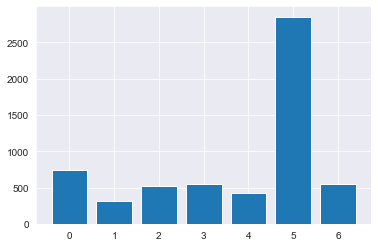

In [10]:
plt.bar(range(7), comm_topic[0])
plt.xticks(range(7))
pass

<BarContainer object of 7 artists>

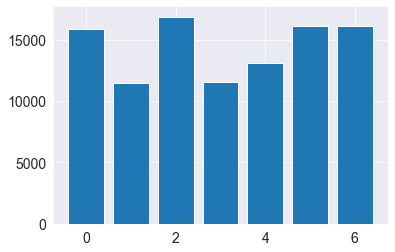

In [79]:
plt.bar(range(7), comm_topic[1])

<BarContainer object of 7 artists>

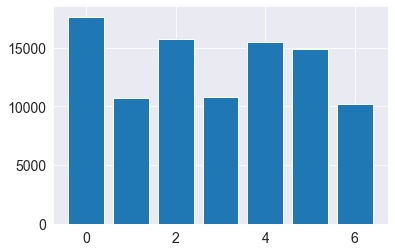

In [80]:
plt.bar(range(7), comm_topic[4])

### 28个社团的话题分布

[(22, 37882),
 (1, 27958),
 (7, 21373),
 (3, 21316),
 (10, 16738),
 (15, 16499),
 (8, 9838),
 (4, 9092),
 (2, 6696),
 (13, 5874),
 (0, 3491),

In [ ]:
plt.bar(range(7), comm_topic[22])
plt.xticks(range(7))

----------

# 找到hashtags相关的第二层!!!

考虑方向

In [3]:
!head disk/second_layer.txt

{"#":["tcot","pjnet"],"userid":703971353351696384,"id":"737848323919335424","n1":"1339835893","n2":"703971353351696384"}
{"#":["maga"],"userid":733828747690811392,"id":"737848331863359488","n1":"759251","n2":"733828747690811392"}
{"#":["imwithher"],"userid":810145062,"id":"737848380832026628","n1":"1339835893","n2":"810145062"}
{"#":["benghazi"],"userid":88071033,"id":"737848406958321666","n1":"2188423838","n2":"88071033"}
{"#":["trump","maga"],"userid":901903482,"id":"737848410779197440","n1":"708560981060784128","n2":"901903482"}
{"#":["neverhillary","trump2016"],"userid":4499094387,"id":"737848433088815104","n1":"620571475","n2":"4499094387"}
{"#":["trump"],"userid":4550874792,"id":"737848434904829953","n1":"1917731","n2":"4550874792"}
{"#":["hillary"],"userid":26957062,"id":"737848457805758464","n1":"4761064634","n2":"26957062"}
{"#":["neverhillary","hillary"],"userid":804041095,"id":"737848470627885056","n1":"2316246829","n2":"804041095"}
{"#":["feelthebern"],"userid":1247798108,"

In [466]:
G = nx.read_gpickle("data/ira-interaction.gp")
G.number_of_nodes(), G.number_of_edges()

(179783, 432429)

In [46]:
# _edges = set()
G = nx.DiGraph(G)

for line in tqdm(open("disk/second_layer.txt")):
    d = json.loads(line.strip())
    n1 = d["n1"]
    n2 = d["n2"]
    if n1 == n2:
        continue
    elif n1 in G.node or n2 in G.node:
        G.add_edge(n1, n2)
        
G.number_of_nodes(), G.number_of_edges(), G.number_of_edges() / G.number_of_nodes()

(380601, 7597394, 19.961571304331834)

In [8]:
G = max(nx.weakly_connected_component_subgraphs(G), key=len)
G.number_of_nodes(), G.number_of_edges(), G.number_of_edges() / G.number_of_nodes()

(380561, 7597368, 19.963601104684926)

In [9]:
putin = Are_you_IRA()

for i, n in enumerate(G.nodes()):
    if putin.fuck(n):
        G.node[n]["IRA"] = 1
    else:
        G.node[n]["IRA"] = 0

In [10]:
nx.write_gpickle(G, "data/IRA-two-layers.gpickle")

In [3]:
G = nx.read_gpickle("data/IRA-two-layers.gpickle")

In [6]:
save_for_matlab(G, "data/ira-int-2-undir.net")
G.number_of_nodes(), G.number_of_edges()

change into undir and get the connected component
380561 7559868


(380561, 7597368)

In [479]:
# for gephi

plot_these_nodes = []
keep_iras = []

for n in G.node():
    if Putin.fuck(n) or G.degree(n) > 30000:
        keep_iras.append(n)
    else:
        plot_these_nodes.append(n)
            
len(plot_these_nodes), len(keep_iras)

(418758, 517)

In [480]:
# random sampling for show
import random

plot_these_nodes = random.sample(plot_these_nodes, int(len(plot_these_nodes) * 0.01))
plot_these_nodes.extend(keep_iras)
sampleG = G.subgraph(plot_these_nodes)
sampleG = sampleG.subgraph(max(nx.weakly_connected_components(sampleG), key=len))
# G = G.subgraph(max(nx.connected_components(G), key=len))
nx.write_gexf(sampleG, "data/IRA-2.gexf")

In [19]:
from build_network import nx2gt

In [20]:
for n in G.nodes():
    try:
        del G.node[n]["IRA"]
    except:
        pass
    try:
        del G.node[n]["id"]
    except:
        pass

In [21]:
gt = nx2gt(G)

converting ...


In [22]:
gt

<Graph object, directed, with 380561 vertices and 7597368 edges at 0x7f4aaecebe80>

In [23]:
gt.save("data/IRA_two_layers.gt")

In [44]:
G.number_of_nodes(), G.number_of_selfloops()

380561

In [382]:
G = gt.load("data/IRA_two_layers.gt")

In [485]:
# G = nx.read_gpickle("data/IRA-two-layers.gpickle")
G = nx.read_gpickle("data/ira-interaction.gp")

In [12]:
G.degree("25073877"), G.out_degree("25073877"), G.in_degree("25073877")

(99145, 99113, 32)

In [13]:
G.degree("1339835893"), G.out_degree("1339835893"), G.in_degree("1339835893")

(90289, 90257, 32)

# 找到hashtags相关的第二层!!（不同社团）

In [481]:
!head disk/second_layer_C1.txt

{"#":["hannity"],"userid":2248442846,"id":"737848312003366913","n1":"25073877","n2":"2248442846"}
{"#":["tcot","pjnet"],"userid":703971353351696384,"id":"737848323919335424","n1":"1339835893","n2":"703971353351696384"}
{"#":["maga"],"userid":733828747690811392,"id":"737848331863359488","n1":"759251","n2":"733828747690811392"}
{"#":["imwithher"],"userid":810145062,"id":"737848380832026628","n1":"1339835893","n2":"810145062"}
{"#":["hannity"],"userid":713895213337559041,"id":"737848382467756033","n1":"25073877","n2":"713895213337559041"}
{"#":["benghazi"],"userid":88071033,"id":"737848406958321666","n1":"2188423838","n2":"88071033"}
{"#":["trump","maga"],"userid":901903482,"id":"737848410779197440","n1":"708560981060784128","n2":"901903482"}
{"#":["neverhillary","trump2016"],"userid":4499094387,"id":"737848433088815104","n1":"620571475","n2":"4499094387"}
{"#":["trump"],"userid":4550874792,"id":"737848434904829953","n1":"1917731","n2":"4550874792"}
{"#":["hillary"],"userid":26957062,"id"

In [482]:
G = nx.read_gpickle("data/ira-interaction.gp")
G.number_of_nodes(), G.number_of_edges()

(179783, 432429)

In [485]:
louvain_rst = json.load(open("data/louvain_rst_4.json"))
from collections import defaultdict

Putin = Are_you_IRA()

comm_nodes = defaultdict(set)

for n, c in louvain_rst.items():
#     if not Putin.check(n):
#         continue
    if c == 0:
        c = 1
    elif c == 1:
        c = 2
    elif c == 3:
        c = 3
    else:
        continue
    comm_nodes[c].add(n)

In [486]:
for cN, userids in comm_nodes.items():
    print("#C", cN)
    _sub_G = G.subgraph(userids)
    _sub_G = nx.DiGraph(_sub_G)
    
    for line in tqdm(open(f"disk/second_layer_C{cN}.txt")):
        d = json.loads(line.strip())
        n1 = d["n1"]
        n2 = d["n2"]
        if n1 == n2:
            continue
        elif n1 in _sub_G.node or n2 in _sub_G.node:
            _sub_G.add_edge(n1, n2)
    
    nx.write_gpickle(_sub_G, f"data/graph/C{cN}-two-layer.gpickle")
    print(_sub_G.number_of_nodes(), _sub_G.number_of_edges(), _sub_G.number_of_edges() / _sub_G.number_of_nodes())

#C 1



316046 7406348 23.43439879004955
#C 3



24914 90784 3.6438949987958575
#C 2



100741 410963 4.079401633892854


In [7]:
import random

# for gephi
for cN in range(1, 4):
    plot_these_nodes = []
    keep_iras = []

    G = nx.read_gpickle(f"data/graph/C{cN}-two-layer.gpickle")
    
    for n in G.node():
        if Putin.check(n) or G.degree(n) > 50000:
            keep_iras.append(n)
        else:
            plot_these_nodes.append(n)

    print(len(plot_these_nodes), len(keep_iras))

    plot_these_nodes = random.sample(plot_these_nodes, int(len(plot_these_nodes) * 0.01))
    plot_these_nodes.extend(keep_iras)
    sampleG = G.subgraph(plot_these_nodes)
    sampleG = sampleG.subgraph(max(nx.weakly_connected_components(sampleG), key=len))
    # G = G.subgraph(max(nx.connected_components(G), key=len))
    for n in G.nodes():
        if Putin.check(n):
            G.node[n]["IRA"] = 1
        else:
            G.node[n]["IRA"] = 0
    nx.write_gexf(sampleG, f"data/graph/C{cN}-two-layer.gexf")

315878 168
100478 263
24802 112


## Analyzing two-layer network

In [43]:
G = nx.read_gpickle("data/IRA-two-layers.gpickle")

In [29]:
from fake_identify import Are_you_IRA

putin = Are_you_IRA()

def get_G_char(g_file):
    print(g_file, "...")
    G = nx.read_gpickle(g_file)
    
    n_nodes = G.number_of_nodes()
    n_edges = G.number_of_edges()
    k = G.number_of_edges() / G.number_of_nodes()

    out_d = pd.Series([k[1] for k in G.out_degree()])
    # print(out_d)
    ave_out_d = out_d.mean()
    std_out_d = out_d.std() / k
    max_out_d = out_d.max()

    in_d = pd.Series([k[1] for k in G.in_degree()])
    # print(in_d)
    ave_in_d = in_d.mean()
    std_in_d = in_d.std() / k
    max_in_d = in_d.max()

    return {
        "N nodes": int(n_nodes),
        "N edges": int(n_edges),
        "<k>": k,
        "std(k_out) / <k>": std_out_d,
        "std(k_in) / <k>": std_in_d,
        "max(k_out)": int(max_out_d),
        "max(k_in)": int(max_in_d),
    }        


def get_G_char_IRA(g_file):
    print(g_file, "...")
    G = nx.read_gpickle(g_file)
    nodes = [n for n in G.node() if Putin.fuck(n)]
    n_nodes = len(nodes)
            
    out_d = pd.Series([G.out_degree(n) for n in nodes])
    ave_k_out = out_d.sum() / n_nodes
    std_k_out = out_d.std() / ave_k_out
    max_out_d = out_d.max()

    in_d = pd.Series([G.in_degree(n) for n in nodes])
    ave_k_in = in_d.sum() / n_nodes
    std_k_in = in_d.std() / ave_k_in
    max_in_d = in_d.max()
    
    return {
        "N nodes": int(n_nodes),
        "<k_out>": ave_k_out,
        "<k_in>": ave_k_in,
        "std(k_out) / <k_out>": std_k_out,
        "std(k_in) / <k_in>": std_k_in,
        # "N cover": len(cover_set),
        "max(k_out)": int(max_out_d),
        "max(k_in)": int(max_in_d),
    }


In [40]:
networks_char1 = get_G_char("data/IRA-two-layers.gpickle")

data/IRA-two-layers.gpickle ...


In [47]:
networks_char = {}
networks_char["Whole"] = networks_char1
networks_char = pd.DataFrame(networks_char).transpose().round(1)
networks_char = networks_char[["N nodes", "N edges", "<k>", "std(k_out) / <k>", "std(k_in) / <k>", "max(k_out)", "max(k_in)"]]
networks_char = networks_char.astype({
    "N nodes": int,
    "N edges": int,
    "max(k_out)": int,
    "max(k_in)": int,
})

networks_char.to_csv("data/two_layers_network.csv", float_format="%.1f")
networks_char

,N nodes,N edges,<k>,std(k_out) / <k>,std(k_in) / <k>,max(k_out),max(k_in)
Whole,380561,7597368,20.0,22.8,3.4,99113,8470


In [48]:
networks_char2 = get_G_char_IRA("data/IRA-two-layers.gpickle")

data/IRA-two-layers.gpickle ...


In [51]:
networks_char = {}
networks_char["IRA"] = networks_char2

networks_char = pd.DataFrame(networks_char).round(1).transpose()
networks_char = networks_char[["N nodes", "<k_out>", "<k_in>", "std(k_out) / <k_out>", "std(k_in) / <k_in>", "max(k_out)", "max(k_in)"]]
networks_char = networks_char.astype({
    "N nodes": int,
    "max(k_out)": int,
    "max(k_in)": int,
})

networks_char.to_csv("data/two_layers_network_IRA.csv", float_format="%.1f")
networks_char

,N nodes,<k_out>,<k_in>,std(k_out) / <k_out>,std(k_in) / <k_in>,max(k_out),max(k_in)
IRA,510,500.2,353.2,8.9,1.8,82012,8470


# Time Series Analysis of two-laryer network

In [542]:
G = nx.read_gpickle("data/IRA-two-layers.gpickle")

In [543]:
# save node

with open("data/two-layers-non-IRA.txt", "w") as f:
    for n in G.nodes():
        if G.node[n]["IRA"] == 0:
            f.write(n + "\n")
            
with open("data/two-layers-IRA.txt", "w") as f:
    for n in G.nodes():
        if G.node[n]["IRA"] == 1:
            f.write(n + "\n")

In [17]:
# read nodes
IRA_nodes = set([line.strip() for line in open("data/two-layers-IRA.txt")])
len(IRA_nodes)

510

In [16]:
IRA_data = pd.read_csv("data/ira-tweets-ele.csv")

In [18]:
IRA_data.columns

Index(['tweetid', 'userid', 'user_display_name', 'user_screen_name',
       'user_reported_location', 'user_profile_description',
       'user_profile_url', 'follower_count', 'following_count',
       'account_creation_date', 'account_language', 'tweet_language',
       'tweet_text', 'tweet_time', 'tweet_client_name', 'in_reply_to_tweetid',
       'in_reply_to_userid', 'quoted_tweet_tweetid', 'is_retweet',
       'retweet_userid', 'retweet_tweetid', 'latitude', 'longitude',
       'quote_count', 'reply_count', 'like_count', 'retweet_count', 'hashtags',
       'urls', 'user_mentions', 'poll_choices'],
      dtype='object')

In [19]:
len(IRA_data.userid.unique())

556

In [20]:
dts = []

for i, row in tqdm(IRA_data.iterrows()):
    u = Putin.uncover(row.userid)
    if u in IRA_nodes:
        dts.append(row.tweet_time)

In [21]:
ts = pd.to_datetime(dts)
ts = ts.value_counts()
ts = ts.resample("15Min").sum()
ts = ts[(ts.index >= "2016-06-01") & (ts.index < "2016-11-09")]

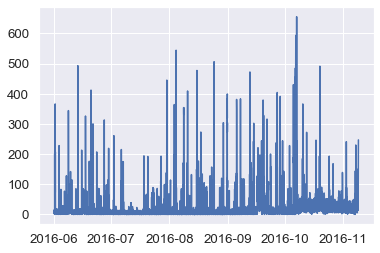

In [23]:
plt.plot(ts)

In [3]:
# read nodes
non_IRA_nodes = set([line.strip() for line in open("data/two-layers-non-IRA.txt")])
len(non_IRA_nodes)

380051

In [4]:
# from pathlib import Path

non_dts = []
for line in tqdm(open('disk/user_time.txt')):
    w = line.strip().split()
    uid = w[1]
    _dt = w[2] + " " + w[3]
    if uid in non_IRA_nodes:
        non_dts.append(_dt)

In [5]:
non_ts = pd.to_datetime(non_dts)
non_ts = non_ts.value_counts()
# non_ts = non_ts.resample("1D").sum()
non_ts = non_ts.resample("15Min").sum()
non_ts = non_ts[(non_ts.index >= "2016-06-01") & (non_ts.index < "2016-11-09")]
# non_ts

### 需要去掉活跃度非常低的时间片段（days）

In [6]:
# import pendulum
# from datetime import datetime
# from datetime import timedelta
# _non_ts = pd.to_datetime(non_dts)
# _non_ts = non_ts.resample("1D").sum()
_non_ts = non_ts
should_remove = _non_ts[_non_ts < 100]
len(should_remove)

1029

In [7]:
should_remove = should_remove.index

In [9]:
from datetime import timedelta

should_remove = [should_remove - timedelta(hours=4)]

In [10]:
with open("data/should_be_removed_in_timeseries.txt", "w") as f:
    for _ss in should_remove[0]:
        f.write(str(_ss) + "\n")

In [30]:
import pendulum

should_remove = set()

for line in open("data/should_be_removed_in_timeseries.txt"):
    _dt = line[ :10]
    should_remove.add(pendulum.parse(_dt).add(hours=4))
    
len(should_remove)

22

In [31]:
from datetime import datetime

should_remove_15Min = []

for _d in should_remove:
    # print(type(_d))
    # print(pd.date_range(start=_d, periods=4 * 24, freq="15Min"))
    for _dt in pd.date_range(start=datetime.fromtimestamp(_d.timestamp()), periods=4 * 24, freq="15Min"):
        should_remove_15Min.append(pd.to_datetime(_dt))

In [24]:
non_ts = non_ts[~non_ts.index.isin(should_remove_15Min)]
ts = ts[~ts.index.isin(should_remove_15Min)]

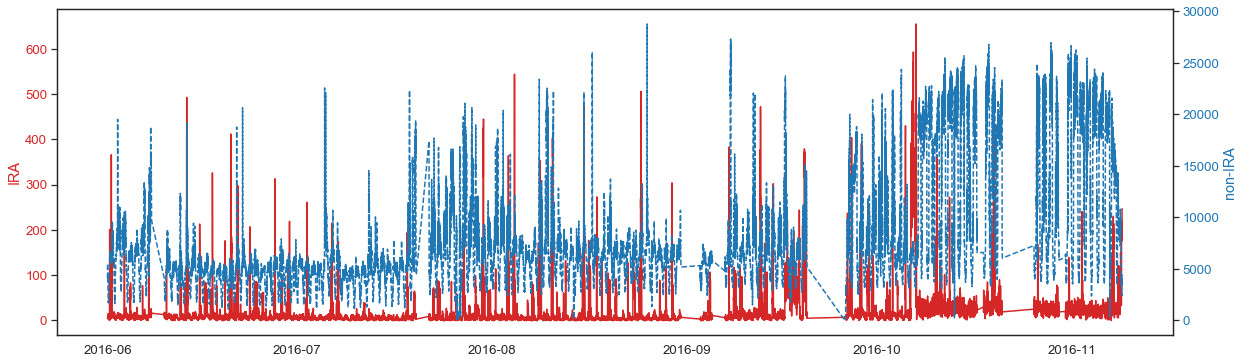

In [25]:
sns.set(style="white", font_scale=1.2)
fig, ax1 = plt.subplots(figsize=(20, 6))
color = 'tab:red'
ax1.set_ylabel('IRA', color=color)  # we already handled the x-label with ax1
ax1.plot(ts, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('non-IRA', color=color)  # we already handled the x-label with ax1
ax2.plot(non_ts, "--", color=color)
ax2.tick_params(axis='y', labelcolor=color)

In [63]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(ts, freq=4)
non_result = seasonal_decompose(non_ts, freq=4)
# print(non_result.trend)
# print(non_result.seasonal)
# print(non_result.resid)
# print(non_result.observed)

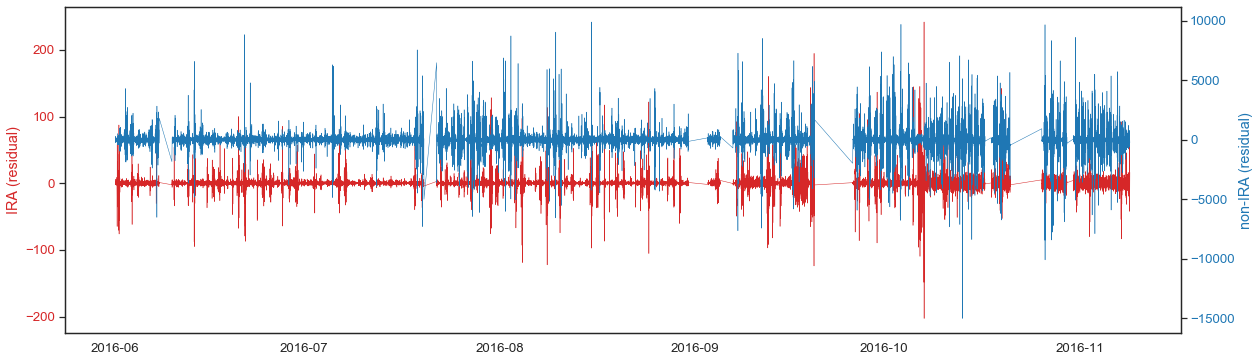

In [64]:
sns.set(style="white", font_scale=1.2)
fig, ax1 = plt.subplots(figsize=(20, 6))
color = 'tab:red'
ax1.set_ylabel('IRA (residual)', color=color)  # we already handled the x-label with ax1
# ax1.set_ylim((-600, 600))
ax1.plot(result.resid, color=color, lw=0.5)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('non-IRA (residual)', color=color)  # we already handled the x-label with ax1
# ax2.set_ylim((-20000, 20000))
ax2.plot(non_result.resid, color=color, lw=0.5)
ax2.tick_params(axis='y', labelcolor=color)

In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests

IRA_resid = result.resid.dropna(); non_resid = non_result.resid.dropna()
for_gra = np.array([non_resid, IRA_resid]).T
print(for_gra)
# np.savetxt("test.txt", for_gra)
grangercausalitytests(for_gra, maxlag=4 * 8)

print('- '* 60)
for_gra = np.array([IRA_resid, non_resid]).T
print(for_gra)
# np.savetxt("test.txt", for_gra)
grangercausalitytests(for_gra, maxlag=4 * 8)

## Three communities > spreading > timeseries analysis

In [487]:
louvain_rst = json.load(open("data/louvain_rst_4.json"))

In [488]:
from collections import defaultdict

comm_nodes = defaultdict(set)

for n, c in louvain_rst.items():
    if c == 0:
        c = 1
    elif c == 1:
        c = 2
    elif c == 3:
        c = 3
    else:
        continue
    comm_nodes[c].add(n)

In [490]:
len(comm_nodes[1]), len(comm_nodes[2]), len(comm_nodes[3])

(137953, 31940, 9624)

In [460]:
G2 = nx.read_gpickle("data/IRA-two-layers.gpickle")

In [138]:
import copy

## 社团扩展第二层，但是扩展的时候用到的是同样一批hashtag

for i in range(4):
    first_layer_nodes = copy.deepcopy(comm_nodes[i])
    for n in comm_nodes[i]:
#         print(n)
        for nj in G2.successors(n):
            first_layer_nodes.add(nj)
        for nj in G2.predecessors(n):
            first_layer_nodes.add(nj)
#     print(len(first_layer_nodes))
    G2_c = nx.DiGraph(G2.subgraph(first_layer_nodes))
    print(G2_c.number_of_nodes(), G2_c.number_of_edges())
    nx.write_gpickle(G2_c, f"data/louvain_2_layers/{i}.gpickle")

321207 7486362
209551 7199455
1220 13774
100112 6248694


In [243]:
from pathlib import Path
import importlib
import build_network
importlib.reload(build_network)

# for graph-tool to calculate CI

for in_name in Path().rglob("data/graph/C*"):
    _G = nx.read_gpickle(in_name)
    _G = build_network.nx2gt(_G)
    _G.save(in_name.name[:-8] + ".gt")

converting ...
converting ...
converting ...
converting ...


In [131]:
G_c0 = nx.read_gpickle("data/louvain_2_layers/0.gpickle")

## 扩展！用不同的hashtags

In [ ]:
from pathlib import Path
import importlib
import build_network
importlib.reload(build_network)

# for graph-tool to calculate CI

for in_name in Path().rglob("data/graph/C*"):
    _G = nx.read_gpickle(in_name)
    _G = build_network.nx2gt(_G)
    _G.save(in_name.name[:-8] + ".gt")

In [32]:
IRA_data = pd.read_csv("data/ira-tweets-ele.csv")

In [89]:
# from stldecompose import decompose, forecast

def analyze_ts_in_communities(cN):
    
    def get_ts(IRA_nodes):
        dts = []
        for i, row in tqdm(IRA_data.iterrows()):
            u = Putin.uncover(row.userid)
            if u in IRA_nodes:
                dts.append(row.tweet_time)
        ts = pd.to_datetime(dts)
        ts = ts.value_counts()
        ts = ts.resample("15Min").sum()
        ts = ts[(ts.index >= "2016-06-01") & (ts.index < "2016-11-09")]
        ts = ts[~ts.index.isin(should_remove_15Min)]
        return ts
    
    def get_non(non_IRA_nodes):
        non_dts = []
        for line in tqdm(open('disk/user_time.txt')):
            w = line.strip().split()
            uid = w[1]
            _dt = w[2] + " " + w[3]
            if uid in non_IRA_nodes:
                non_dts.append(_dt)

        non_ts = pd.to_datetime(non_dts)
        non_ts = non_ts.value_counts()
        non_ts = non_ts.resample("15Min").sum()
        non_ts = non_ts[(non_ts.index >= "2016-06-01") & (non_ts.index < "2016-11-09")]
        non_ts = non_ts[~non_ts.index.isin(should_remove_15Min)]
        return non_ts
    
    G = nx.read_gpickle(f"data/graph/C{cN}-two-layer.gpickle")
    IRA_nodes = set([n for n in G.nodes if Putin.check(n)])
    non_IRA_nodes = set([n for n in G.nodes if not Putin.check(n)])
#     print(len(IRA_nodes), len(non_IRA_nodes))
    
#     ts = get_ts(IRA_nodes)
#     non_ts = get_non(non_IRA_nodes)
    
    # abandon
#     from statsmodels.tsa.seasonal import seasonal_decompose
#     non_sd_result = seasonal_decompose(non_ts, freq=96, two_sided=False)
#     sd_result = seasonal_decompose(ts, freq=96, two_sided=False)
#     sd_result = decompose(ts, period=96)
# #     sd_result.plot()
#     non_sd_result = decompose(non_ts, period=96)
#     tsts = pd.DataFrame({"ts": ts, "non_ts": non_ts, "ts_resid": sd_result.resid, "non_resid": non_sd_result.resid})
#     tsts.to_pickle(f"disk/tsts/C{cN}.pickle")
    
#     tsts = tsts[tsts.index < "2016-06-07"]

    tsts = pd.read_pickle(f"data/tsts/C{cN}.pickle")
    sns.set(style="white", font_scale=1.2)
    fig, ax1 = plt.subplots(figsize=(20, 6))
    color = 'tab:red'
    ax1.set_ylabel('IRA', color=color)  # we already handled the x-label with ax1
    ax1.plot("ts", data=tsts, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:blue'
    ax2.set_ylabel('non-IRA', color=color)  # we already handled the x-label with ax1
    ax2.plot("non_ts", data=tsts, color=color, lw=0.8)
    ax2.tick_params(axis='y', labelcolor=color)
    plt.savefig(f"fig/c{cN}-ts.pdf", dpi=300)
    plt.show()
    plt.close()
    
    tsts_resid = pd.read_pickle(f"data/tsts/resid_C{cN}.pickle")
    # print(tsts_resid)
    sns.set(style="white", font_scale=1.2)
    fig, ax1 = plt.subplots(figsize=(20, 6))
    color = 'tab:red'
    ax1.set_ylabel('IRA (residuals)', color=color)  # we already handled the x-label with ax1
    # ax1.set_ylim((-600, 600))
    ax1.plot("ts", data=tsts_resid, color=color, lw=1)
    ax1.tick_params(axis='y', labelcolor=color)
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:blue'
    ax2.set_ylabel("non-IRA (residuals)", color=color)  # we already handled the x-label with ax1
    # ax2.set_ylim((-20000, 20000))
    ax2.plot("non_ts", data=tsts_resid, color=color, lw=1)
    ax2.tick_params(axis='y', labelcolor=color)
    plt.savefig(f"fig/c{cN}-resid.pdf", dpi=300)
    plt.show()
    plt.close()
    
    # 因果分析
    
    from statsmodels.tsa.stattools import grangercausalitytests
    
    
    for_gra = np.array([tsts_resid.non_ts.dropna(), tsts_resid.ts.dropna()]).T
#     print(for_gra)
    
    print(" ---------------------- IRA causes non-IRA ----------------------")
    r1 = grangercausalitytests(for_gra, maxlag=24, verbose=False)
    for _k, v in r1.items():
        print(f'''lag={_k}\tF={v[0]['ssr_ftest'][0]:.3f}\tp-value={v[0]['ssr_ftest'][1]:.3f}''')

    for_gra = np.array([tsts_resid.ts.dropna(), tsts_resid.non_ts.dropna()]).T
#     print(for_gra)
    print(" ---------------------- non-IRA causes IRA ----------------------")
    r2 = grangercausalitytests(for_gra, maxlag=24, verbose=False)
    for _k, v in r2.items():
        print(f'''lag={_k}\tF={v[0]['ssr_ftest'][0]:.3f}\tp-value={v[0]['ssr_ftest'][1]:.3f}''')

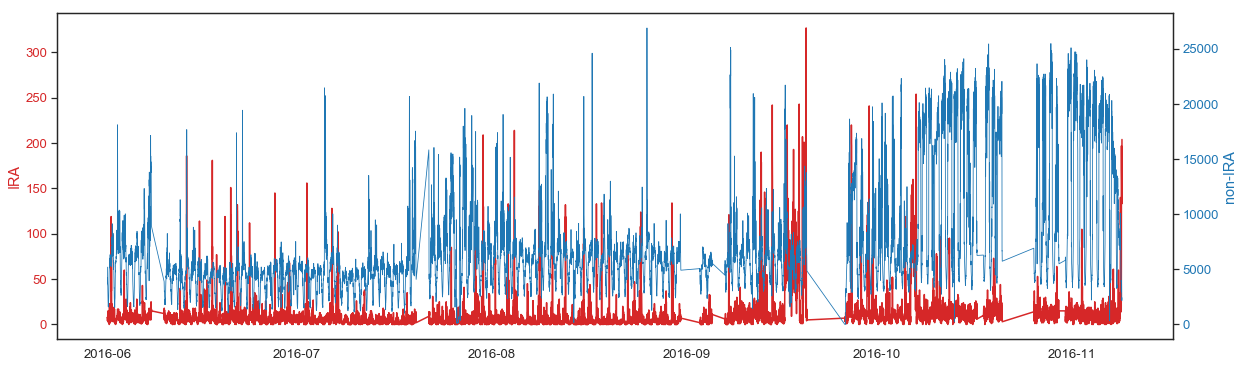

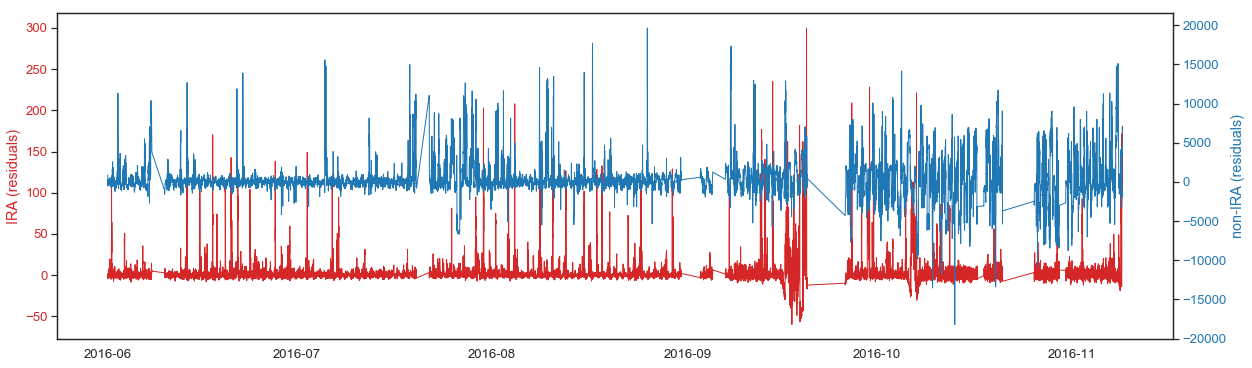

 ---------------------- IRA causes non-IRA ----------------------
lag=1	F=0.067	p-value=0.796
lag=2	F=2.336	p-value=0.097
lag=3	F=3.472	p-value=0.015
lag=4	F=3.948	p-value=0.003
lag=5	F=3.165	p-value=0.007
lag=6	F=2.657	p-value=0.014
lag=7	F=2.306	p-value=0.024
lag=8	F=2.114	p-value=0.031
lag=9	F=1.910	p-value=0.046
lag=10	F=2.018	p-value=0.028
lag=11	F=1.840	p-value=0.042
lag=12	F=1.903	p-value=0.029
lag=13	F=1.770	p-value=0.042
lag=14	F=1.672	p-value=0.054
lag=15	F=1.623	p-value=0.060
lag=16	F=1.606	p-value=0.059
lag=17	F=1.626	p-value=0.049
lag=18	F=1.537	p-value=0.067
lag=19	F=1.464	p-value=0.087
lag=20	F=1.400	p-value=0.110
lag=21	F=1.588	p-value=0.043
lag=22	F=1.515	p-value=0.058
lag=23	F=1.583	p-value=0.038
lag=24	F=1.515	p-value=0.051
 ---------------------- non-IRA causes IRA ----------------------
lag=1	F=0.501	p-value=0.479
lag=2	F=0.449	p-value=0.638
lag=3	F=0.608	p-value=0.609
lag=4	F=0.697	p-value=0.594
lag=5	F=0.559	p-value=0.732
lag=6	F=0.551	p-value=0.769
lag=7	F=0.695

In [90]:
analyze_ts_in_communities(1)

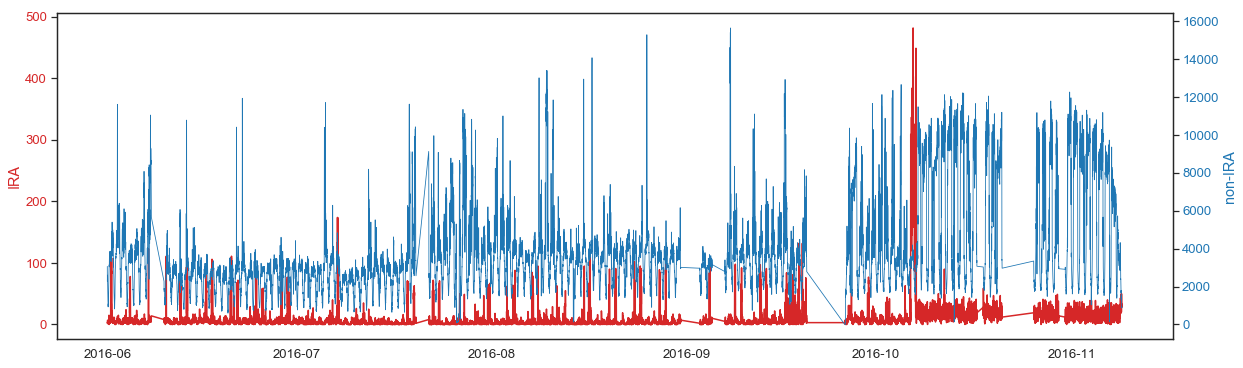

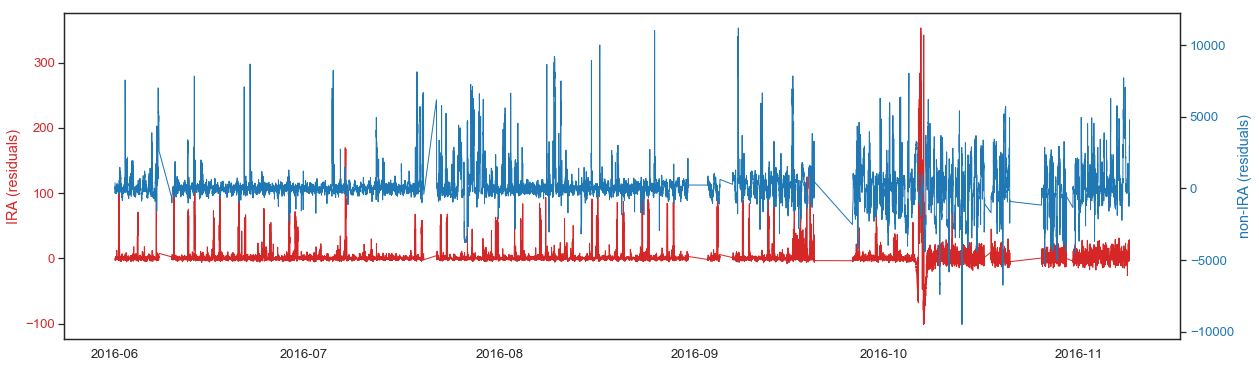

 ---------------------- IRA causes non-IRA ----------------------
lag=1	F=2.207	p-value=0.137
lag=2	F=1.276	p-value=0.279
lag=3	F=0.879	p-value=0.451
lag=4	F=0.870	p-value=0.481
lag=5	F=2.027	p-value=0.072
lag=6	F=1.765	p-value=0.102
lag=7	F=1.606	p-value=0.129
lag=8	F=1.667	p-value=0.101
lag=9	F=1.477	p-value=0.150
lag=10	F=1.414	p-value=0.167
lag=11	F=1.318	p-value=0.207
lag=12	F=1.239	p-value=0.249
lag=13	F=1.143	p-value=0.316
lag=14	F=1.187	p-value=0.278
lag=15	F=1.133	p-value=0.319
lag=16	F=1.066	p-value=0.383
lag=17	F=1.075	p-value=0.372
lag=18	F=1.091	p-value=0.353
lag=19	F=1.037	p-value=0.412
lag=20	F=0.990	p-value=0.471
lag=21	F=0.964	p-value=0.506
lag=22	F=1.108	p-value=0.328
lag=23	F=1.071	p-value=0.370
lag=24	F=1.072	p-value=0.367
 ---------------------- non-IRA causes IRA ----------------------
lag=1	F=0.024	p-value=0.876
lag=2	F=0.003	p-value=0.997
lag=3	F=0.253	p-value=0.859
lag=4	F=0.188	p-value=0.945
lag=5	F=0.356	p-value=0.879
lag=6	F=0.328	p-value=0.922
lag=7	F=0.391

In [81]:
analyze_ts_in_communities(2)

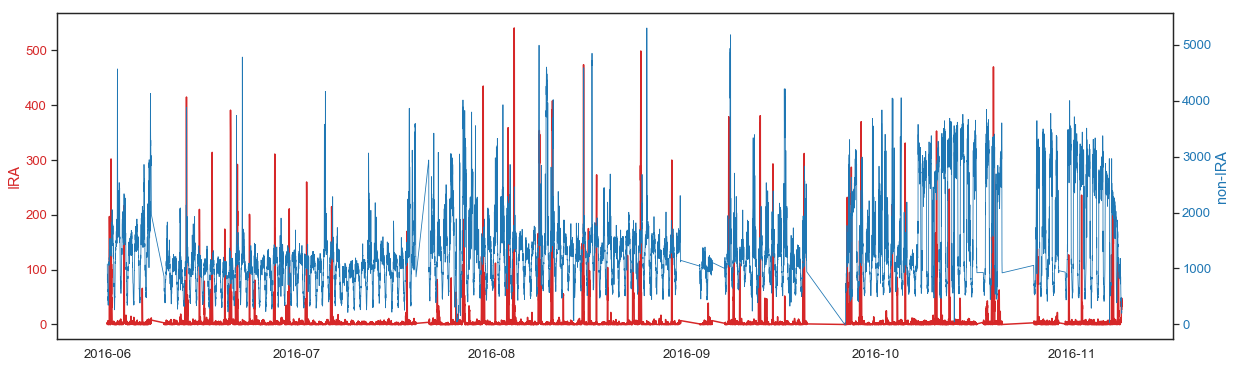

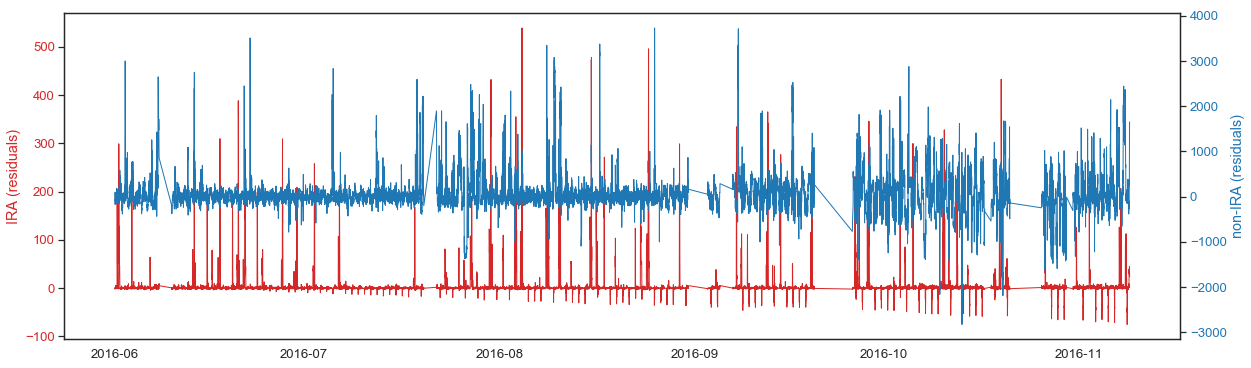

 ---------------------- IRA causes non-IRA ----------------------
lag=1	F=3.139	p-value=0.076
lag=2	F=2.260	p-value=0.104
lag=3	F=10.612	p-value=0.000
lag=4	F=7.940	p-value=0.000
lag=5	F=6.772	p-value=0.000
lag=6	F=5.664	p-value=0.000
lag=7	F=6.459	p-value=0.000
lag=8	F=6.223	p-value=0.000
lag=9	F=5.692	p-value=0.000
lag=10	F=5.307	p-value=0.000
lag=11	F=5.033	p-value=0.000
lag=12	F=4.634	p-value=0.000
lag=13	F=4.330	p-value=0.000
lag=14	F=4.062	p-value=0.000
lag=15	F=3.796	p-value=0.000
lag=16	F=3.848	p-value=0.000
lag=17	F=3.663	p-value=0.000
lag=18	F=3.497	p-value=0.000
lag=19	F=3.315	p-value=0.000
lag=20	F=3.259	p-value=0.000
lag=21	F=3.114	p-value=0.000
lag=22	F=3.013	p-value=0.000
lag=23	F=2.868	p-value=0.000
lag=24	F=2.732	p-value=0.000
 ---------------------- non-IRA causes IRA ----------------------
lag=1	F=0.377	p-value=0.539
lag=2	F=1.257	p-value=0.284
lag=3	F=2.043	p-value=0.106
lag=4	F=2.691	p-value=0.029
lag=5	F=3.693	p-value=0.002
lag=6	F=3.141	p-value=0.004
lag=7	F=2.79

In [82]:
analyze_ts_in_communities(3)

In [56]:
from pyloess import stl
    
#%% LOESS smoothing

# remove seasonality and trend

stl_params = dict(np = 96, # period of season
    ns = 95, # seasonal smoothing
    nt = None, # trend smooting int((1.5*np)/(1-(1.5/ns)))
    nl = None, # low-pass filter leat odd integer >= np
    isdeg=1,
    itdeg=1,
    ildeg=1,
    robust=True,
    ni = 1,
    no = 5)

for i in range(1, 4):
    resid = pd.DataFrame(index=tsts.index)
    tsts = pd.read_pickle(f"data/tsts/C{i}.pickle")

    for col in ["ts", "non_ts"]:
        resid[col] = stl(tsts[col].values, **stl_params).residuals
        # print(stl(tsts[col].values, **stl_params))
    
    resid.to_pickle(f"data/tsts/resid_C{i}.pickle")

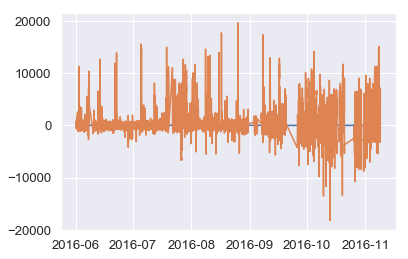

In [21]:
dftrend = pd.DataFrame(index=tsts.index)
dfseasonal = pd.DataFrame(index=tsts.index)
dfresiduals = pd.DataFrame(index=tsts.index)

for col in stl_res_dict.keys():
    dftrend[col] = stl_res_dict[col].trend
    dfseasonal[col] = stl_res_dict[col].seasonal
    dfresiduals[col] = stl_res_dict[col].residuals

tsts["non_ts"]
plt.plot(dfresiduals)

## Assortativity of two-layer network

Compute the assortativeity based on https://www.pnas.org/content/115/16/4057

In [17]:
def compute_M(G, sub=False):
    
    IRA_list = []
    for n in G.nodes:
        if Putin.check(n):
            G.nodes[n]["IRA"] = 1
            IRA_list.append(n)
            # print(G.nodes[n])
        else:
            G.nodes[n]["IRA"] = 0
    
    if sub:
        G = get_the_first_layer(G)
    
    e00 = 0
    e01 = 0
    e10 = 0
    e11 = 0

    for e in G.edges():
        s, t = G.nodes[e[0]]['IRA'], G.nodes[e[1]]['IRA']
        if s == 0 and t == 0:
            e00 += 1
        elif s == 0 and t == 1:
            e01 += 1
        elif s == 1 and t == 0:
            e10 += 1
        elif s == 1 and t == 1:
            e11 += 1
        else:
            print('error!')
    print(nx.attribute_assortativity_coefficient(G, "IRA"))
    M = (e11 + e00 - e01 * e10 - e10 * e01) / (1 - e01 * e10 - e10 * e01) / 2 / G.number_of_edges()
    print(e00, e01, e10, e11, M)
    return M

In [16]:
def get_the_first_layer(G):
    _G = nx.DiGraph()
    for e in G.edges():
        s, t = G.nodes[e[0]]['IRA'], G.nodes[e[1]]['IRA']
        if s == 1 or t == 0:
            _G.add_edge(e)
    return _G

In [18]:
G = nx.read_gpickle("data/graph/C1-two-layer.gpickle")
compute_M(G)
compute_M(G, sub=True)
G = nx.read_gpickle("data/graph/C2-two-layer.gpickle")
compute_M(G)
compute_M(G, sub=True)
G = nx.read_gpickle("data/graph/C3-two-layer.gpickle")
compute_M(G)
compute_M(G, sub=True)

-0.006797808476201691
7124046 40856 241053 393 6.748523677936116e-08


TypeError: add_edge() missing 1 required positional argument: 'v_of_edge'